In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import tensorflow as tf
import numpy as np
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

2025-04-29 16:41:05.519516: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 16:41:05.535402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745937665.554284   25927 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745937665.559992   25927 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745937665.574458   25927 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        out = F.log_softmax(x, dim=1)
        return out, x

# Training settings
batch_size = 64
epochs = 10
learning_rate = 0.01

# Data loading and preprocessing
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [0.7, 0.3])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

# Training loop
best_model = copy.deepcopy(model)
best_loss = 1
for epoch in range(1, epochs + 1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)[0]
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        # if batch_idx % 100 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item()))

    # Validation
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)[0]
            validation_loss += loss_function(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    validation_loss = validation_loss/len(validation_loader)

    accuracy = correct / len(validation_loader.dataset)
    print("Train Epoch: {}\tValidation Loss: {:.6f}\tValidation Accuracy: {:.2f}%".format(epoch, validation_loss, accuracy*100))
    if validation_loss < best_loss:
        best_model = copy.deepcopy(model)
        best_loss = validation_loss

Train Epoch: 1	Validation Loss: 0.368280	Validation Accuracy: 89.36%
Train Epoch: 2	Validation Loss: 0.277417	Validation Accuracy: 92.05%
Train Epoch: 3	Validation Loss: 0.235439	Validation Accuracy: 93.06%
Train Epoch: 4	Validation Loss: 0.207325	Validation Accuracy: 93.84%
Train Epoch: 5	Validation Loss: 0.182952	Validation Accuracy: 94.48%
Train Epoch: 6	Validation Loss: 0.166249	Validation Accuracy: 95.04%
Train Epoch: 7	Validation Loss: 0.147601	Validation Accuracy: 95.54%
Train Epoch: 8	Validation Loss: 0.135467	Validation Accuracy: 95.94%
Train Epoch: 9	Validation Loss: 0.125290	Validation Accuracy: 96.33%
Train Epoch: 10	Validation Loss: 0.116132	Validation Accuracy: 96.61%


In [4]:
def plot_predictions(image_list, model, output_probs=False, adversarial=False):
    '''
    Evaluate images against trained model and plot images.
    If adversarial == True, replace middle image title appropriately
    Return probability list if output_probs == True
    '''

    image_list = image_list.to(device)
    prob = model.eval()
    with torch.no_grad():
        output = model(image_list)[1]
        prob = F.softmax(output, dim=1).cpu().numpy()
    
    pred_list = np.argmax(prob, axis=1)
    pct_list = np.max(prob, axis=1)*100
    
    # Setup image grid
    import math
    cols = 3
    rows = math.ceil(image_list.shape[0]/cols)
    fig = plt.figure(1, (12., 12.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates grid of axes
                     axes_pad=0.5,  # pad between axes in inch.
                     )
    
    # Get probs, images and populate grid
    for i in range(len(prob)):
        pred_list[i] = np.argmax(prob[i]) # for mnist index == classification
        pct_list[i] = prob[i][pred_list[i]] * 100

        image = image_list[i].cpu().numpy().reshape(28,28)
        grid[i].imshow(image, cmap='gray')
        
        grid[i].set_title('Label: {} \nCertainty: {:.1f}%' \
                          .format(pred_list[i], 
                                  pct_list[i]))
        
        # Only use when plotting original, partial deriv and adversarial images
        if (adversarial) & (i % 3 == 1): 
            grid[i].set_title("Adversarial \nPartial Derivatives")
        
    plt.show()
    
    return prob if output_probs else None

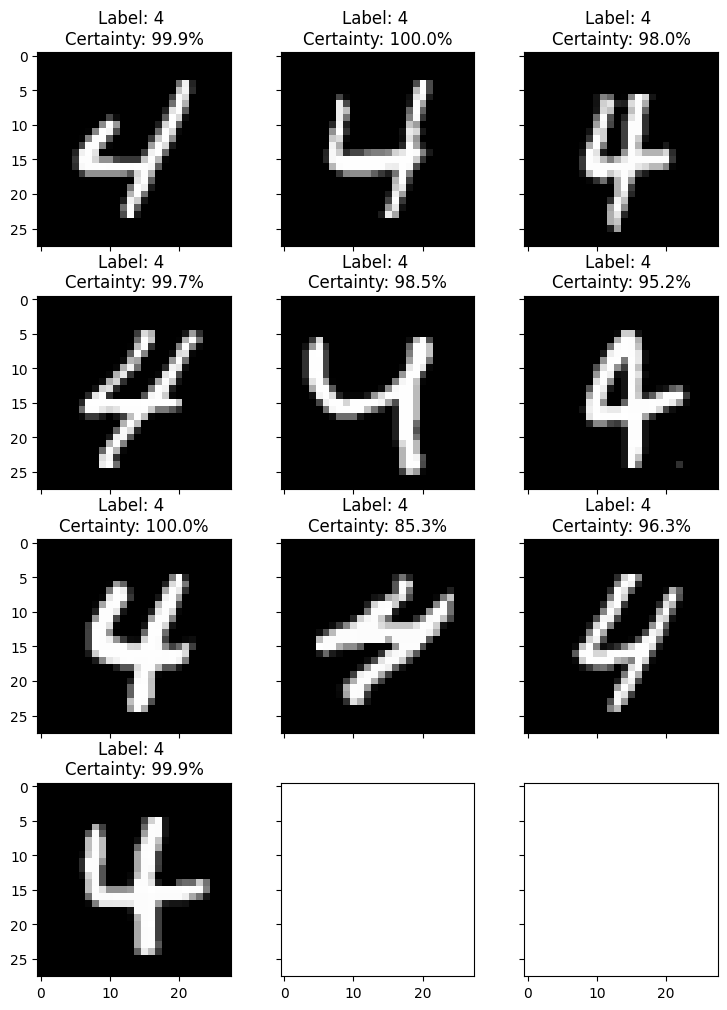

In [5]:

indices_4 = [i for i, (x, y) in enumerate(test_dataset) if y==4]
# indices_4 = indices_4[0:10]
mnist_4 = torch.utils.data.Subset(test_dataset, indices_4)
loader_4 = torch.utils.data.DataLoader(mnist_4, batch_size=10, shuffle=True)

images, _ = next(iter(loader_4))

plot_predictions(images, model)

In [22]:
def create_plot_adversarial_images(x_image, y_label, model, lr=0.1, n_steps=1, output_probs=False):
    
    original_image = x_image
    probs_per_step = []

    x = tf.random.normal([1, 784])
    print(x_image.shape)
    x_image.to(device)
    model.eval()
    
    for _ in range(n_steps):
        x_image.requires_grad = True  # Enable gradient calculation for the image

        # Zero the gradients of the model
        model.zero_grad()
        
        output = model(x_image)

        loss = nn.CrossEntropyLoss()(output[1], y_label)
        
        # Compute gradients with respect to the input image
        loss.backward()

        # Get the gradient of the image with respect to the loss
        grad = x_image.grad.data

        # Create adversarial image by adding perturbation in the direction of the gradient
        image_adv = x_image - lr * torch.sign(grad) / n_steps
        image_adv = torch.clamp(image_adv, 0, 1)  # Ensure pixel values are within valid range

        # Convert images to NumPy arrays for plotting
        img_adv_list = [original_image[0].cpu().detach().numpy().reshape(1, 28, 28)]  # Reshape back to 28x28 for plotting
        img_adv_list.append(grad[0].cpu().detach().numpy().reshape(1, 28, 28))  # Gradient/perturbation
        img_adv_list.append(image_adv[0].cpu().detach().numpy().reshape(1, 28, 28))  # Adversarial image

        # Print/plot images and return probabilities
        probs = plot_predictions(torch.tensor(img_adv_list), model, output_probs=output_probs, adversarial=True)
        probs_per_step.append(probs) if output_probs else None

        x_image = image_adv.detach()
    
    return probs_per_step

In [7]:
# Pick a random 4 image 
# Create adversarial image and with target label 9

#Give image 4 but lable 9

indices_4 = [i for i, (x, y) in enumerate(test_dataset) if y==4] 
rand_index = np.random.randint(0, len(indices_4))
image_norm = torch.utils.data.Subset(test_dataset, [indices_4[rand_index]])



for batch_idx, (data, target) in enumerate(image_norm):
    image_norm = data[0].reshape(1, 1, 28, 28).to(device)
    break
    
label_adv = torch.Tensor([9]).long().to(device) # adversarial label 9

In [28]:
z = torch.randn(1, 1, 28, 28).to(device)

torch.Size([1, 1, 28, 28])


/tmp/ipykernel_25927/2017309581.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  probs = plot_predictions(torch.tensor(img_adv_list), model, output_probs=output_probs, adversarial=True)


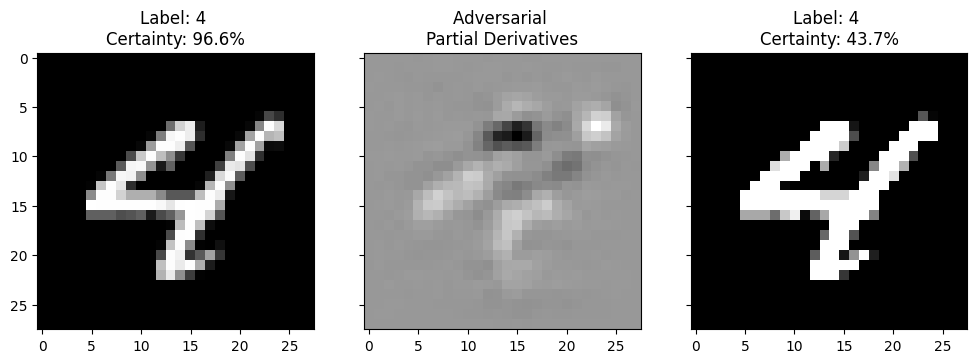

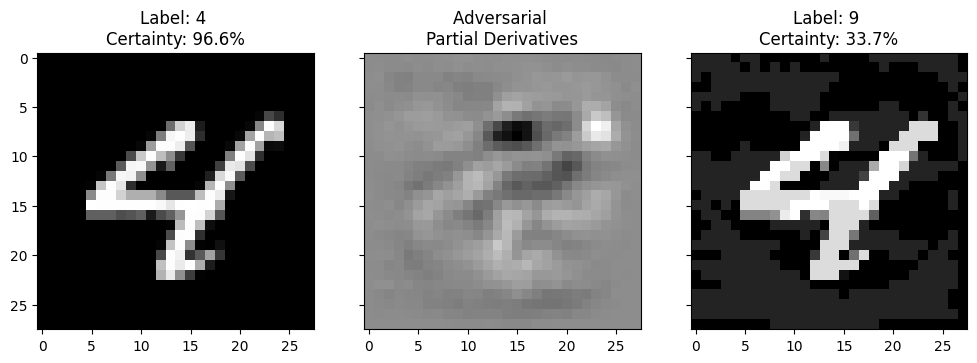

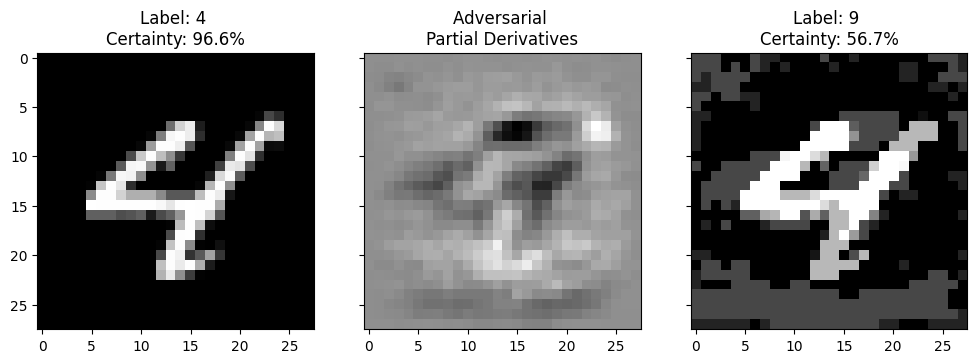

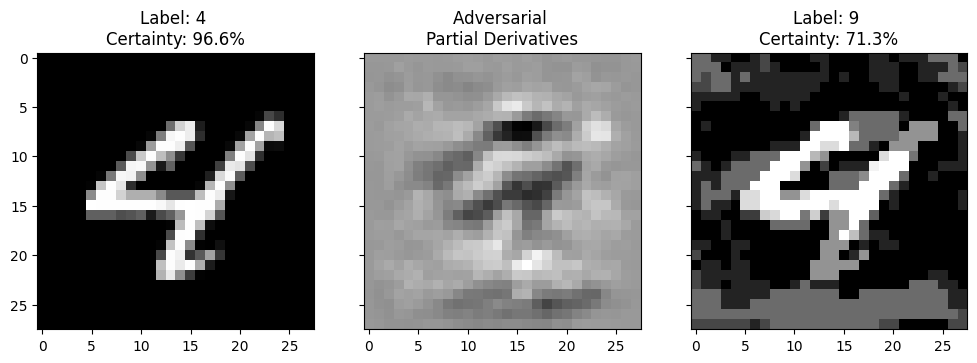

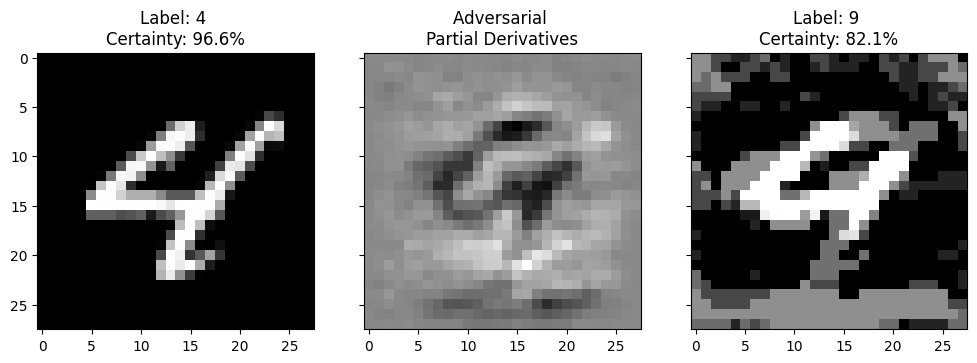

[]

In [14]:
# Plot adversarial images
# Over each step, model certainty changes from 4 to 9
create_plot_adversarial_images(image_norm, label_adv, best_model, lr=0.7, n_steps=5)

torch.Size([1, 1, 28, 28])


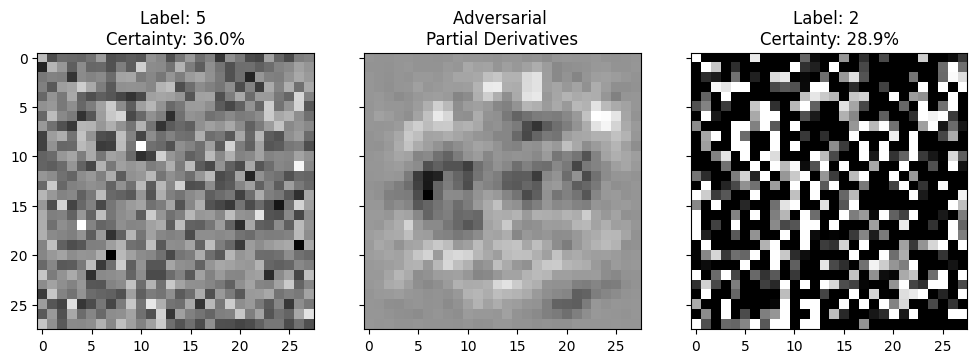

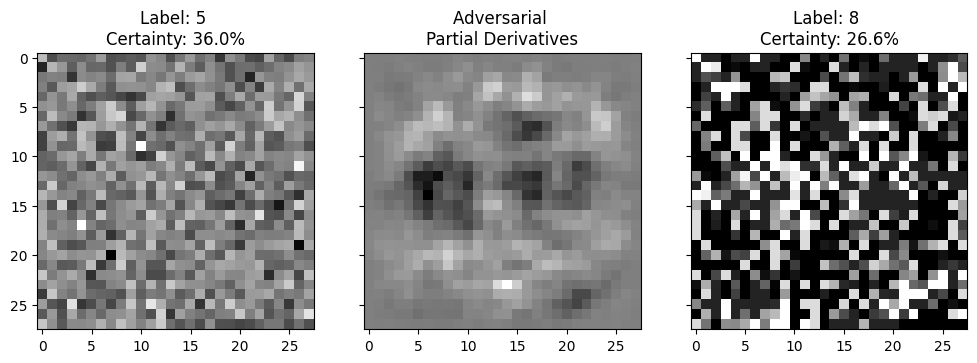

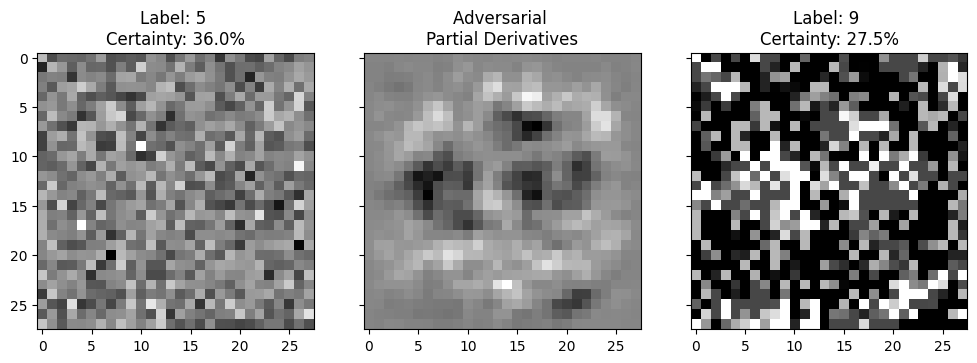

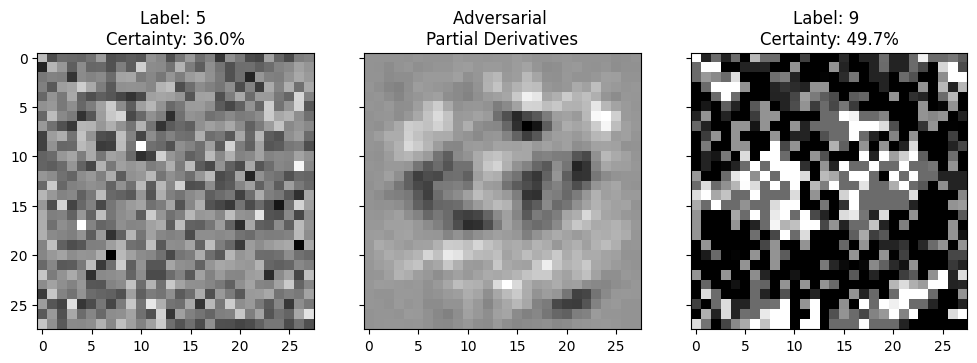

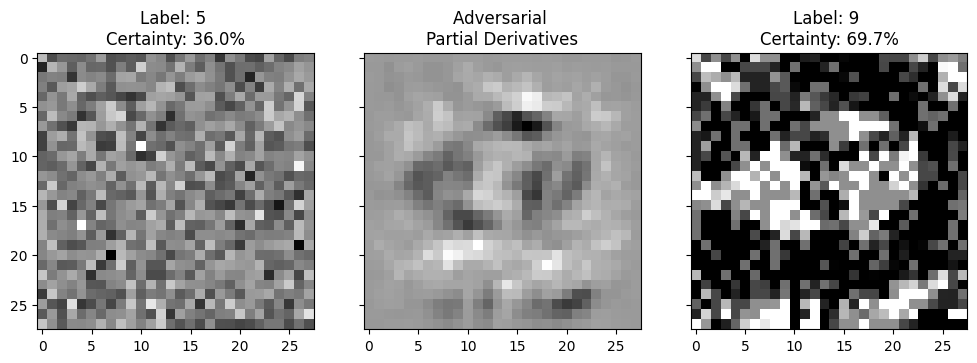

[]

In [30]:
create_plot_adversarial_images(z, label_adv, best_model, lr=0.7, n_steps=5)